In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Table Of Contents

* [EDA](#EDA)
* [Feature Engineering](#Feature-Engineering)
* [Training and Modeling](#Training-and-Modeling)
* [Prediction](#Prediction)

In [2]:
train_df = pd.read_csv('train.csv', index_col=0)
test_df = pd.read_csv('test.csv',index_col=0)

<a id="EDA"></a>
# EDA

In [3]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='Survived', ylabel='count'>

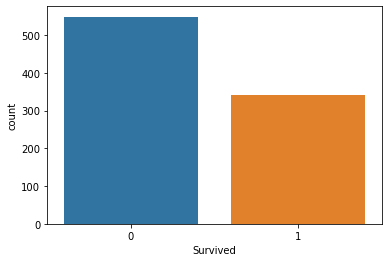

In [6]:
sns.countplot(x='Survived',data=train_df)

<AxesSubplot:xlabel='Sex', ylabel='count'>

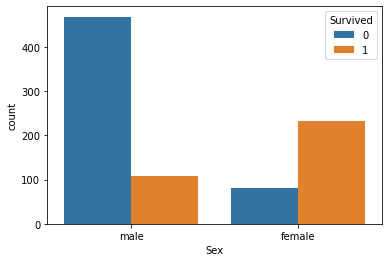

In [7]:
sns.countplot(x='Sex', data=train_df, hue='Survived')

<AxesSubplot:xlabel='Pclass', ylabel='count'>

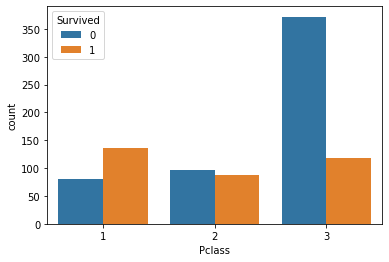

In [8]:
sns.countplot(x='Pclass', data=train_df, hue='Survived')

<AxesSubplot:xlabel='Embarked', ylabel='count'>

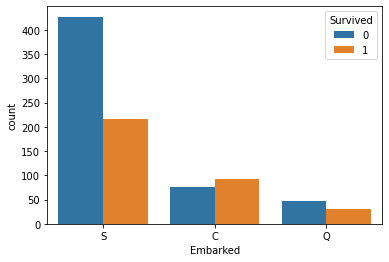

In [9]:
sns.countplot(x='Embarked', data=train_df, hue='Survived')

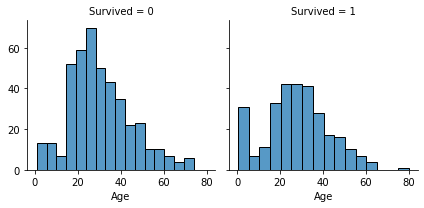

In [10]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(sns.histplot, 'Age')

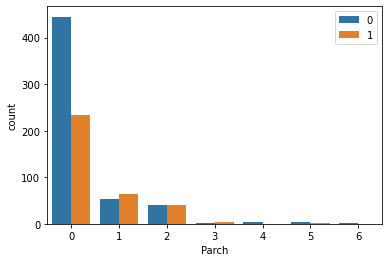

In [11]:
sns.countplot(x='Parch',data=train_df,hue='Survived')
plt.legend(loc='upper right')

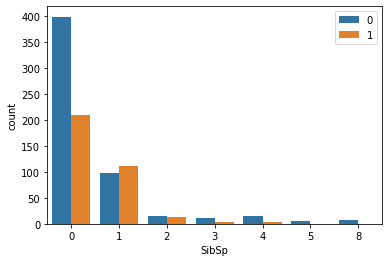

In [12]:
sns.countplot(x='SibSp',data=train_df,hue='Survived')
plt.legend(loc='upper right')

<a id="Feature-Engineering"></a>
#  Feature Engineering

##  Missing Values

In [13]:
# check how many null values in each column
train_df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [14]:
test_df.isnull().sum()

Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

In [15]:
# find average age values by pclass
train_df.groupby('Pclass').mean()['Age']

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [16]:
# create function that will convert null values to average age values depends on plcass
def fill_age(age_pclass):
    age = age_pclass[0]
    pclass = age_pclass[1]
    if pd.isna(age):
        if pclass == 1:
            return 38
        elif pclass == 2:
            return 30
        elif pclass == 3:
            return 25
    else:
        return age

# apply function to Age column of train data to fill in null values
train_df['Age'] = train_df[['Age', 'Pclass']].apply(fill_age, axis=1)
test_df['Age'] = test_df[['Age', 'Pclass']].apply(fill_age, axis=1)

In [17]:
# analyze values in cabin column
train_df['Cabin'].value_counts()

B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: Cabin, Length: 147, dtype: int64

In [18]:
# drop cabin column
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

In [19]:
# fill null values in Fare column in test data with mean value
test_df['Fare'].fillna(train_df['Fare'].mean(), inplace=True)

# fill null values in Embarked column in train data with mode value
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0][0], inplace=True)

In [20]:
# check if the column is all filled with values
train_df.isnull().sum()

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

In [21]:
test_df.isnull().sum()

Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Ticket      0
Fare        0
Embarked    0
dtype: int64

## Drop Irrelevant Features

In [22]:
# drop columns that are not effective on survival
train_df.drop(['Name','Ticket'], axis=1, inplace=True)
test_df.drop(['Name','Ticket'], axis=1, inplace=True)

## Categorical Features

In [23]:
# convert categorical values to numerical values in 'Sex' and 'Embarked' columns
train_df = pd.get_dummies(train_df,drop_first=True)
test_df = pd.get_dummies(test_df,drop_first=True)

## Final Data

In [24]:
train_df.sample(n=10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,
837,0,3,21.0,0,0,8.6625,1,0,1
455,0,3,25.0,0,0,8.0500,1,0,1
874,0,3,47.0,0,0,9.0000,1,0,1
142,1,3,22.0,0,0,7.7500,0,0,1
574,1,3,25.0,0,0,7.7500,0,1,0
575,0,3,16.0,0,0,8.0500,1,0,1
860,0,3,25.0,0,0,7.2292,1,0,0
872,1,1,47.0,1,1,52.5542,0,0,1
358,0,2,38.0,0,0,13.0000,0,0,1


<a id="Training-and-Modeling"></a>
# Model Selection and Training

In [25]:
# check X dataframe
X = train_df.drop('Survived', axis=1)

In [26]:
# create y dataframe
y = train_df['Survived']

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
# separate into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, accuracy_score

import warnings 
warnings.filterwarnings("ignore")

In [30]:
# define models and parameters
logistic_model = LogisticRegression()
logistic_grid = {
    'solver' : ['lbfgs','newton-cg', 'sag', 'saga'],
    'penalty' : ['l1', 'l2', 'elasticnet', None],
    'C' : [100, 10, 1.0, 0.1, 0.01],
}

KNN_model = KNeighborsClassifier()
KNN_grid = {
    'n_neighbors' : range(1,21,2),
    'weights' : ['uniform','distance'],
    'p' : np.arange(1,2,0.10)
} 

SVM_model = SVC()
SVM_grid = {
    'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
    'C' : [0.01, 0.1, 1, 10, 100],
    'gamma' : ['scale', 0.01, 0.03, 0.1, 0.3, 1.0, 3.0]
}

RF_model = RandomForestClassifier()
RF_grid = {
    'n_estimators' : [25, 50, 100, 150],
    'max_features' :  ['sqrt', 'log2', None],
    'max_depth' : [3, 6, 9],
    'max_leaf_nodes' : [3, 6, 9]
}


lst = [(logistic_model, logistic_grid),
       (KNN_model, KNN_grid),
       (RF_model, RF_grid)]


In [31]:
# results
for model, grid in lst:
    # define grid search
    grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy')
    grid_result = grid_search.fit(X_train, y_train)
    estimator = grid_result.best_estimator_
    predictions = estimator.predict(X_test)
    
    # print out best score and best estimator ofr the model
    print('Best score on Gridsearch: ', grid_result.best_score_)
    print('Using: ', estimator)
    print('\n')
    
    # print out classification report on test data for each model
    print(classification_report(predictions, y_test))
    print('Accuracy Score: ', accuracy_score(predictions, y_test))
    print('--'*40)
    

Best score on Gridsearch:  0.800998765570643
Using:  LogisticRegression(C=0.1)


              precision    recall  f1-score   support

           0       0.92      0.84      0.88       159
           1       0.68      0.81      0.74        64

    accuracy                           0.83       223
   macro avg       0.80      0.83      0.81       223
weighted avg       0.85      0.83      0.84       223

Accuracy Score:  0.8340807174887892
--------------------------------------------------------------------------------
Best score on Gridsearch:  0.7470317585007293
Using:  KNeighborsClassifier(n_neighbors=17, p=1.0, weights='distance')


              precision    recall  f1-score   support

           0       0.77      0.79      0.78       143
           1       0.61      0.59      0.60        80

    accuracy                           0.72       223
   macro avg       0.69      0.69      0.69       223
weighted avg       0.72      0.72      0.72       223

Accuracy Score:  0.717488789

<a id="Prediction"></a>
# Prediction

In [32]:
# select a model with highest accuracy score
final_model = RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9, n_estimators=50)
final_model.fit(X_train,y_train)
final_prediction = final_model.predict(test_df)

In [34]:
# convert prediction into dataframe
# index = pd.read_csv('/kaggle/input/titanic/test.csv')['PassengerId']
# outcome_df = pd.DataFrame({"PassengerId": index,"Survived": final_prediction})

# # export as csv file
# outcome_df.to_csv("submission.csv",index = False)